Data Extraction

In [169]:
import numpy as np
import matplotlib.pyplot as plt

def load_train_images():
    with open(r"D:\OneDrive\Desktop\College\MrM Research\Coding\archive\train-images-idx3-ubyte", 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28, 28)

def load_train_labels():
    with open(r"D:\OneDrive\Desktop\College\MrM Research\Coding\archive\train-labels-idx1-ubyte", 'rb') as f:
        return np.frombuffer(f.read(), np.uint8, offset=8)

def load_test_images():
    with open(r"D:\OneDrive\Desktop\College\MrM Research\Coding\archive\t10k-images-idx3-ubyte", 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28, 28)

def load_test_labels():
    with open(r"D:\OneDrive\Desktop\College\MrM Research\Coding\archive\t10k-labels-idx1-ubyte", 'rb') as f:
        return np.frombuffer(f.read(), np.uint8, offset=8)


Data Preprocessing

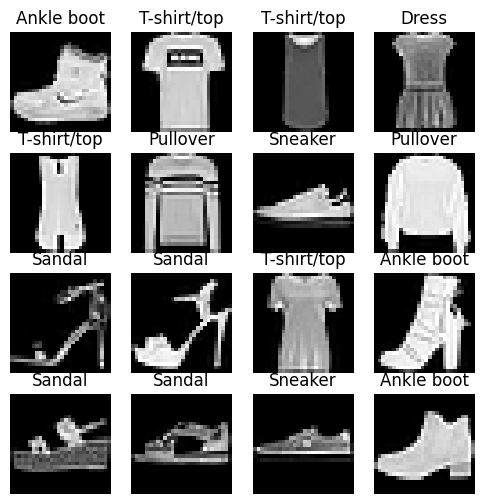

In [170]:

X_train = load_train_images()
y_train = load_train_labels()

X_test = load_test_images()
y_test = load_test_labels()

X_train = X_train / 255.0
X_test = X_test / 255.0
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()

X = X_train.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)


Data Augmentation(experimental)

In [171]:
def random_shift(image, max_shift=2):
    dx = np.random.randint(-max_shift, max_shift + 1)
    dy = np.random.randint(-max_shift, max_shift + 1)
    return np.roll(np.roll(image, dx, axis=0), dy, axis=1)

def add_noise(image, noise_std=0.02):
    noise = np.random.normal(0, noise_std, image.shape)
    return np.clip(image + noise, 0, 1)
def augment_image(image):
    if np.random.rand() < 0.5:
        image = random_shift(image)


    if np.random.rand() < 0.3:
        image = add_noise(image)

    return image


Hyperparameters

In [172]:
input_size = 784
hidden_size = 128
output_size = 10
dropout_rate = 0.2
num_epochs = 20
batch_size = 128
learning_rate = 0.001
l2_lambda= 1e-4

He Initialization

In [173]:
def he_init(fan_in, fan_out):
    return np.random.randn(fan_in, fan_out) * np.sqrt(2.0 / fan_in)

W1 = he_init(input_size, hidden_size)
b1 = np.zeros(hidden_size)

W2 = he_init(hidden_size, output_size)
b2 = np.zeros(output_size)

Activation Function

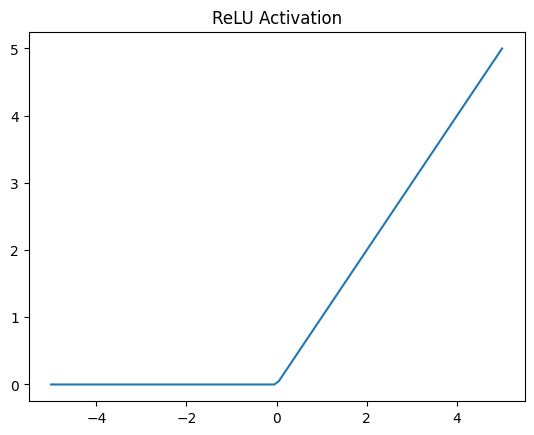

In [174]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)
x = np.linspace(-5, 5, 100)
plt.plot(x, relu(x))
plt.title("ReLU Activation")
plt.show()


More Functions

In [175]:

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
def cross_entropy(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(np.log(y_pred[np.arange(m), y_true] + 1e-8)) / m


Forward propagation

In [176]:

#forward
def forward_prop(X, params, training=True):
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]

    Z1 = X @ W1 + b1
    A1 = relu(Z1)

    if training:
        dropout_mask = (np.random.rand(*A1.shape) > dropout_rate)
        A1 = A1 * dropout_mask / (1 - dropout_rate)
    else:
        dropout_mask = np.ones_like(A1)

    Z2 = A1 @ W2 + b2
    A2 = softmax(Z2)

    cache = {
        "X": X,
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2,
        "dropout_mask": dropout_mask
    }

    return A2, cache


In [177]:

def confusion_matrix(X, y, params, num_classes=10):
    A2, _ = forward_prop(X, params, training=False)
    y_pred = np.argmax(A2, axis=1)

    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y, y_pred):
        cm[true, pred] += 1

    return cm
def accuracy(X, y, params):
    A2, _ = forward_prop(X, params, training=False)
    preds = np.argmax(A2, axis=1)
    return np.mean(preds == y)

Backward propagation

In [178]:
def backward_prop(y, params, cache):
    W2 = params["W2"]
    X = cache["X"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]

    m = y.shape[0]
    # Output layer
    dZ2 = A2.copy()
    dZ2[np.arange(m), y] -= 1
    dZ2 /= m
    dW2 = A1.T @ dZ2 + l2_lambda * W2
    db2 = np.sum(dZ2, axis=0)

    # Hidden layer
    dA1 = dZ2 @ W2.T
    dA1 *= cache["dropout_mask"] / (1 - dropout_rate)
    dZ1 = dA1 * relu_derivative(Z1)

    dW1 = X.T @ dZ1 + l2_lambda * params["W1"]
    db1 = np.sum(dZ1, axis=0)


    grads = {
        "W1": dW1, "b1": db1,
        "W2": dW2, "b2": db2
    }

    return grads


Adam optimiser

In [179]:
def init_adam(params):
    adam = {}
    for key in params:
        adam["m_" + key] = np.zeros_like(params[key])
        adam["v_" + key] = np.zeros_like(params[key])
    adam["t"] = 0
    return adam
def adam_update(params, grads, adam,
                lr=0.001,
                beta1=0.9,
                beta2=0.999,
                eps=1e-8):
    
    adam["t"] += 1
    t = adam["t"]
    
    for key in params:
        # Update biased first moment
        adam["m_" + key] = beta1 * adam["m_" + key] + (1 - beta1) * grads[key]
        
        # Update biased second moment
        adam["v_" + key] = beta2 * adam["v_" + key] + (1 - beta2) * (grads[key] ** 2)
        
        # Bias correction
        m_hat = adam["m_" + key] / (1 - beta1 ** t)
        v_hat = adam["v_" + key] / (1 - beta2 ** t)
        
        # Parameter update
        params[key] -= lr * m_hat / (np.sqrt(v_hat) + eps)
params = {
    "W1": W1, "b1": b1,
    "W2": W2, "b2": b2
}


adam = init_adam(params)


Mini-Batch

In [180]:
y = y_train
train_acc_history = []
test_acc_history = []
loss_history = []

num_samples = X.shape[0]

for epoch in range(num_epochs):
    perm = np.random.permutation(num_samples)
    X_shuffled, y_shuffled = X[perm], y[perm]
    epoch_loss = 0

    for i in range(0, num_samples, batch_size):

        # ----- get batch -----
        Xb = X_shuffled[i:i+batch_size].copy()
        yb = y_shuffled[i:i+batch_size]

        # ----- data augmentation (decided to remove it) -----
        """Xb_imgs = Xb.reshape(-1, 28, 28)
        for j in range(len(Xb_imgs)):
            Xb_imgs[j] = augment_image(Xb_imgs[j])
        Xb = Xb_imgs.reshape(-1, 784)"""


        # ----- forward pass -----
        A2, cache = forward_prop(Xb, params, training=True)

        # ----- data loss only -----
        data_loss = cross_entropy(yb, A2)
        epoch_loss += data_loss

        # ----- backward + update -----
        grads = backward_prop(yb, params, cache)
        adam_update(params, grads, adam, lr=learning_rate)

    # ----- L2 loss ONCE per epoch -----
    l2_loss = 0.5 * l2_lambda * (
        np.sum(params["W1"]**2) + np.sum(params["W2"]**2)
    )

    epoch_loss = (epoch_loss / max(1, num_samples // batch_size)) + l2_loss
    loss_history.append(epoch_loss)

    # ----- accuracy ONCE per epoch -----
    train_acc_history.append(accuracy(X, y_train, params))
    test_acc_history.append(accuracy(X_test_flat, y_test, params))


Visualisations

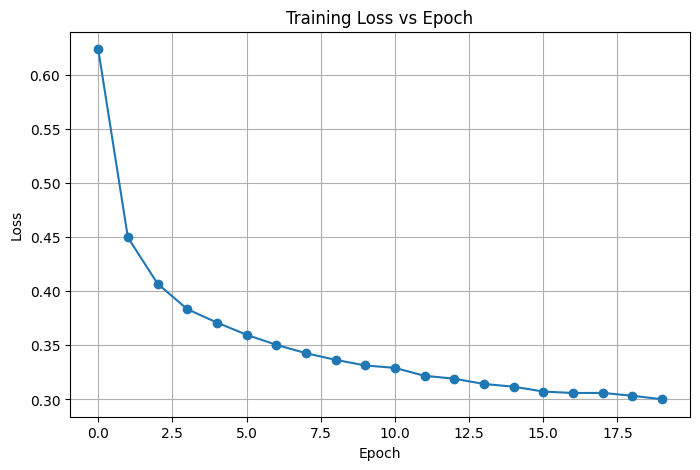

In [181]:
plt.figure(figsize=(8,5))
plt.plot(range(len(loss_history)), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.grid(True)
plt.show()

In [182]:
print("Train accuracy:", accuracy(X, y_train, params))
print("Test accuracy :", accuracy(X_test_flat, y_test, params))




Train accuracy: 0.9186
Test accuracy : 0.8866


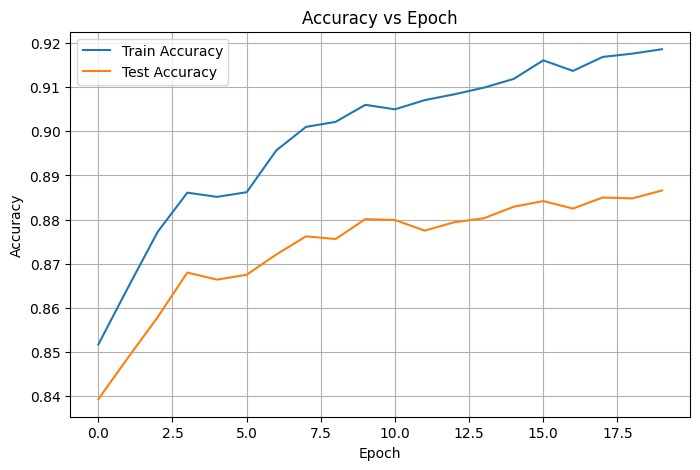

In [183]:
plt.figure(figsize=(8,5))
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.show()


[[814   1  19  23   3   1 129   0  10   0]
 [  3 964   2  24   3   0   4   0   0   0]
 [ 16   0 845  12  68   0  58   0   1   0]
 [ 13   2  13 904  31   0  32   0   5   0]
 [  1   1 113  30 784   0  68   0   3   0]
 [  0   0   0   1   0 952   0  30   2  15]
 [103   1  96  30  54   0 699   0  17   0]
 [  0   0   0   0   0   7   0 966   1  26]
 [  3   0   3   4   2   1   7   4 976   0]
 [  0   0   0   0   0   4   1  33   0 962]]


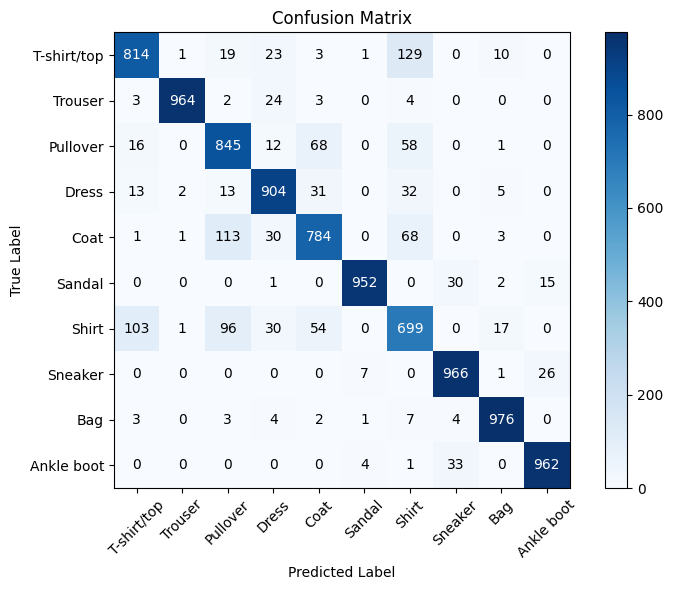

In [184]:
cm = confusion_matrix(X_test_flat, y_test, params)
print(cm)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.xticks(range(10), class_names, rotation=45)
plt.yticks(range(10), class_names)

for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()
